In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import geodatasets

# Идеальный вид (Data mining/Data analytics)
### Описание решения
1. Проанализировать данные <https://www.kaggle.com/datasets/stealthtechnologies/earthquakes-dataset> и <https://www.kaggle.com/datasets/andrewmvd/tsunami-dataset>, чтобы определиться с подходящими странами
2. Проанализировать страны, в которых китайцам можно свободно купить недвижимость
3. Отдельно проанализировать выбранные страны на годовое количество катаклизмов, на наличие морей/океанов и наличие безопасных мест для постройки дома

### Решение

##### Таблица землетрясений

In [2]:
earthshake_df = pd.read_csv("earthshake_data.csv")

earthshake_df.replace("", np.nan, inplace=True)
earthshake_df.dropna(inplace=True)

earthshake_df["Depth (km)"] = pd.to_numeric(earthshake_df["Depth (km)"], errors="coerce")
earthshake_df["Magnitude"] = pd.to_numeric(earthshake_df["Magnitude"], errors="coerce")

earthshake_df["Latitude"] = earthshake_df["Latitude"].str.extract(r"(\d+\.\d+)")[0].astype(
    float
) * earthshake_df["Latitude"].str.extract(r"([NS])")[0].map({"N": 1, "S": -1})

earthshake_df["Longitude"] = earthshake_df["Longitude"].str.extract(r"(\d+\.\d+)")[
    0
].astype(float) * earthshake_df["Longitude"].str.extract(r"([EW])")[0].map(
    {"E": 1, "W": -1}
)

earthshake_df["type"] = np.zeros(earthshake_df.shape[0]).astype(np.int32).tolist()
earthshake_df.dropna()

earthshake_df = earthshake_df[["Region", "Latitude", "Longitude", 'type']]

earthshake_df.head(5)

,Region,Latitude,Longitude,type
0,"Mindanao, Philippine",8.01,125.20,0
1,Near Coast of Venezuela,10.80,-62.65,0
2,"Near East Coast of Honshu, japan",37.16,141.09,0
3,Near Coast of Peru,-15.79,-74.47,0
4,Afghanistan-Tajikistan Border Region,36.36,71.45,0


##### Таблица Цунами

In [3]:
tsunami_df = pd.read_csv('tsunami_data.csv')

# tsunami_df.replace("", np.nan, inplace=True)
# tsunami_df.dropna(inplace=True)

tsunami_df = tsunami_df[["REGION", "LATITUDE", "LONGITUDE"]]
tsunami_df = tsunami_df.rename(
    columns={"LATITUDE": "Latitude", "LONGITUDE": "Longitude", "REGION": "Region"}
)

tsunami_df['type'] = np.ones(tsunami_df.shape[0]).astype(np.int32).tolist()

# tsunami_df.dropna()

tsunami_df.head(10)

,Region,Latitude,Longitude,type
0,Mediterranean Sea,40.00,25.000,1
1,Northeast Atlantic Ocean,51.45,-2.583,1
2,Mediterranean Sea,36.08,36.250,1
3,"China, North and South Korea, Philippines, Taiwan",40.00,128.000,1
4,Mediterranean Sea,39.96,26.240,1
5,"China, North and South Korea, Philippines, Taiwan",37.50,119.500,1
6,"China, North and South Korea, Philippines, Taiwan",37.00,126.000,1
7,Northeast Atlantic Ocean,38.40,-28.100,1
8,Japan,33.10,139.800,1
9,Japan,31.90,140.000,1


##### Объединение двух таблиц

In [4]:
df = pd.concat([earthshake_df, tsunami_df], axis=0)

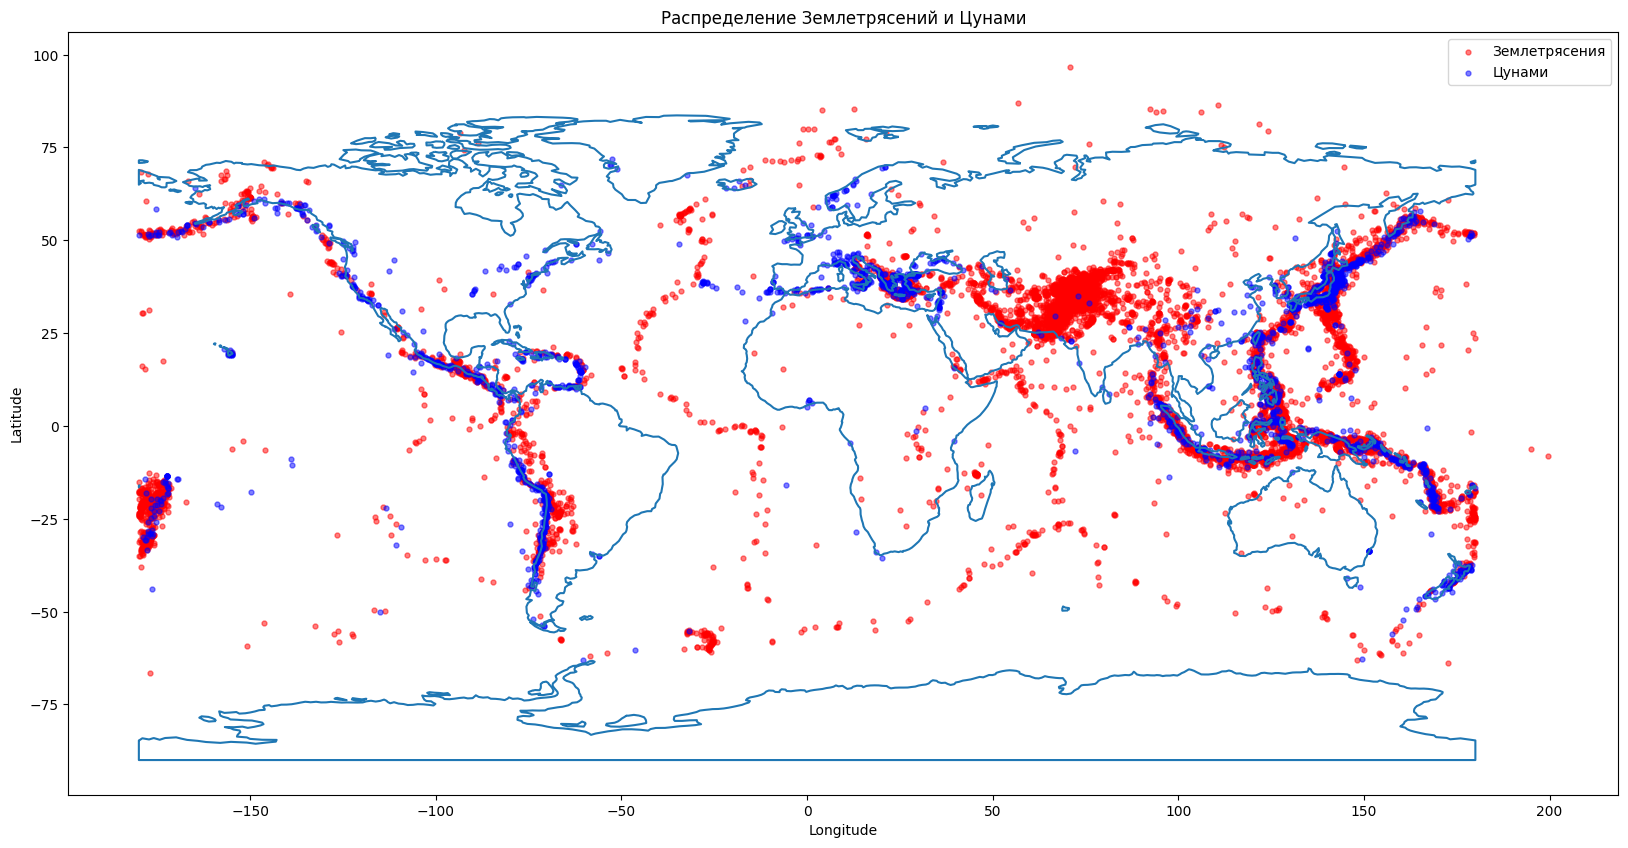

In [5]:
def create_graphic(df: pd.DataFrame, world, disaster_type: int, disaster_name: str, color: str, ax):
    df = df[df['type'] == disaster_type]
    df = df[df["Longitude"] <= 250]
    df = df[df["Latitude"] <= 100]

    # Convert Longitude and Latitude to appropriate numerical values
    df["Longitude"] = df["Longitude"].astype(float)
    df["Latitude"] = df["Latitude"].astype(float)

    # Create a GeoDataFrame
    geometry = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]
    geo_df = gpd.GeoDataFrame(df, geometry=geometry)

    # Plot the map
    
    geo_df.plot(
        ax=ax, markersize=50, color=color, alpha=0.5, marker=".", label=disaster_name
    )

# Load a world map
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))
fig, ax = plt.subplots(figsize=(20, 10))  # Adjust the figsize for a larger plot
world.boundary.plot(ax=ax)

create_graphic(df, world, 0, "Землетрясения", "red", ax)
create_graphic(df, world, 1, "Цунами", "blue", ax)

plt.title("Распределение Землетрясений и Цунами")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

##### Анализ карты
1. Видно, что на востоке больше всего землятресений и цунами, поэтому там лучше дом не выбирать
2. На западе наоборот есть несколько мест, к которым можно присмотреться. Например, южное побережье США, где достаточно много катаклизмов, но есть безопасные места, откуда их видно.
3. Также есть север Африки, где землятресений почти нет, но видно множество цунами
4. Аналогично с Африкой есть Автралия
5. Вероятно, есть некоторые выбросы, так как вряд ли может быть цунами в центре Африки

Таким образом, имеет смысл рассмотреть США, Бразилию, Австралию, Северную Африку

![title](../img/Задание%202%20выбор%20мест%20для%20дома.png)

#### Выбор метрики
Можно выбрать и больше стран, но я решил ограничиться областями, выделенными зеленым, так как они достаточно удалены от природных катаклизмов, но из них всё равно можно видеть "природу".

Таким образом, основная метрика выбора дома - отсутсвие кружочков рядом с городом/штатом и видимость возможных цунами/землетрясений
#### Выбор стран на основе возможности покупки недвижимости гражданам КНР
##### США
1. Исходя из информации с [сайта]( https://nonresidentinvestor.com/chinese-buying-us-real-estate), можно быть уверенным, что граждане Китая могут купить недвижимость в США без особых проблем
2. Так как нужен вид у побережья, то можно рассмотреть покупку дома в штатах: Техас и Северную Каролину, так как они довольно безопасные и можно увидеть некоторые цунами, например, в Каролине - западное побережье
##### Бразилия
1. В этой стране тоже можно свободно приобрести [недвижимость](https://www.benoitproperties.com/news/a-guide-to-buying-property-in-brazil-as-a-foreigner)
2. Из городов больше всего подходит Сан-Луис, Форталеза
##### Африка
1. Можно рассмотреть Нигерию, Камерун, в этих странах должно быть всё хорошо с покупкой дома, на графике видно, что в этих местах особо нет природных катаклизмов, но из них может быть видно целых 4 цунами!

2. Север Африки: тут больше всего подходит Египет, это уже довольно опасная зона, потому что в Александрии было цунами и на противоположном побережье огромное количество водных катаклизмов. Однако если выбрать города, например, Тобрук или Аль-Байда, находящиеся западней по побережью от Александрии, то до них уже последствия этих опасностей не доходят. Таким образом, строить дом вероятней надо именно в одном из этих городов, так как законы для нерезидентов это [позволяют](https://iwandevelopments.com/buying-real-estate-in-egypt/#:~:text=Regardless%20of%20nationality%2C%20foreigners%20buying,purchase%20real%20estate%20in%20Egypt.)

##### Австралия
1. С [покупкой жилья](https://iwandevelopments.com/buying-real-estate-in-egypt/#:~:text=Regardless%20of%20nationality%2C%20foreigners%20buying,purchase%20real%20estate%20in%20Egypt.) здесь всё сложнее, чем с прошлыми вариантами, так как надо быть постоянным жителем для такой процедуры, но есть возможность подать заявку на получение разрешения через Совет по обзору иностранных инвестиций, поэтому если мистер Чен готов жить в Австралии, то это может быть один из лучших вариантов, потому что цунами тут полно!
2. Из подходящих вариантов - города западного побережья, например, Таунсвилл, так как с них открывается вид на цунами в Коралловом море

### Вывод

В ходе анализа данных о природных катаклизмах и сайтов с инофрмацией о покупке недвижимости было выявлено несколько мест для будущего дома: Египет, Автсралия, Бразилия, США, Нигерия и Камерун